In [1]:
import datetime
import os
import sys
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from astropy import convolution
import galsim
from galsim import roman
from galsim import InterpolatedImage, Image
import webbpsf
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, psf, gs, color

100%|██████████| 3/3 [03:32<00:00, 70.78s/it]


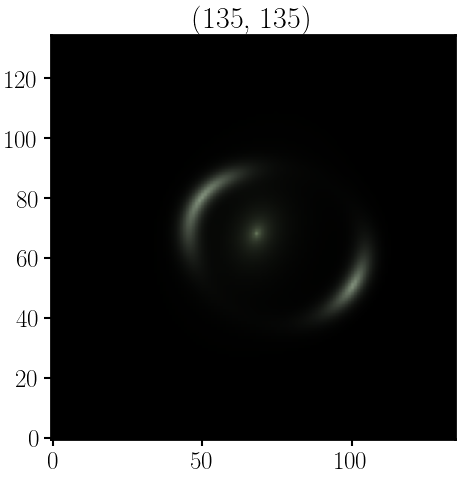

In [2]:
oversample_factor = 3

bands = util.hydra_to_dict(config.pipeline)['band']
exposure_time = util.hydra_to_dict(config.pipeline)['exposure_time']

lens = SampleStrongLens()
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'pyhalo', 'cdm_subhalos_tuple')))

models = []
for band in tqdm(bands):
    model = lens.get_array(num_pix=45 * oversample_factor, side=4.95, band=band)
    models.append(model)

color_model = color.get_rgb(image_b=models[0], image_g=models[1], image_r=models[2])

plot.plot(color_model, title=model.shape)

In [ ]:
# create galsim rng
rng = galsim.UniformDeviate()

# determine detector and position
detector = gs.get_random_detector()
detector_pos = gs.get_random_detector_pos()

# get wcs
wcs = gs.get_random_hlwas_wcs()

In [112]:
for i, band in enumerate(bands):
    array = models[i]

    # get flux
    total_flux_cps = lens.get_total_flux_cps(band)  
    
    # get interpolated image
    interp = galsim.InterpolatedImage(galsim.Image(array), scale=0.11 / oversample_factor, flux=total_flux_cps * exposure_time)

    # generate PSF and convolve
    convolved = gs.convolve()
    
    # add sky background
    sky_bkg = gs.get_sky_bkg()

    # add sky background to convolved image
    final_image = convolved + sky_bkg

    # integer number of photons are being detected, so quantize
    final_image.quantize()

    # add all detector effects
    galsim.roman.allDetectorEffects(final_image, prev_exposures=(), rng=rng, exptime=exposure_time)

    # quantize, as the analog-to-digital converter reads in an integer value
    final_image.quantize()

    # this has float values, so convert to integer values
    final_image = galsim.Image(final_image, dtype=int).array

375.2308550377718
